In [21]:
import sys
sys.path = ["../.."] + sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

In [22]:
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

读取数据

In [23]:
# 红系成熟部分
adata = scv.read("/mnt/h/F_bak/PyCode/xijing/notebook/data/Gastrulation/erythroid_lineage.h5ad")
# sc.pp.subsample(adata, n_obs=500)
# 这里就不能在随机抽样了，为了与之前抽样作比较，这里需要与之前的细胞完全一致
adata2 = scv.read("./tmp/erythroid_lineage2/adata/adata.h5ad")
adata = adata[list(adata2.obs.index)].copy()
batch_key = "stage"
cluster_key = "celltype"
adata

AnnData object with n_obs × n_vars = 500 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

预处理

In [24]:
batch_pair_list = None
batch_pair_list = [
    ["E7.0", "E7.25"],
    ["E7.25", "E7.5"],
    ["E7.5", "E7.75"],
    ["E7.75", "E8.0"],
    ["E8.0", "E8.25"],
    ["E8.25", "E8.5"],
]
knn_mask, bnn_mask, subsample_adata = velovgi.pp.preprocess(adata, sample_mode="random", batch_key=batch_key, batch_pair_list=batch_pair_list)

Filtered out 51490 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
calculating knn and bnn mask...
pair_list : [['E7.0', 'E7.25'], ['E7.25', 'E7.5'], ['E7.5', 'E7.75'], ['E7.75', 'E8.0'], ['E8.0', 'E8.25'], ['E8.25', 'E8.5']]
smoothing...
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## 断点训练

In [26]:
import math
from pytorch_lightning import loggers

max_epochs = 500
sep=100
model_epoch_sep_savedir = "./tmp/model_epoch_sep"


# velovgi.tl.VELOVGI.setup_anndata(adata=subsample_adata, spliced_layer="Ms", unspliced_layer="Mu")
# velovgi_model = velovgi.tl.VELOVGI(subsample_adata)

# for i in range(math.ceil(max_epochs/sep)):
#     print(i)
#     name = "erythroid_lineage_%dst_%d_epoch(max_epochs=%d)"%(i+1, sep, max_epochs)
#     logger = loggers.TensorBoardLogger(save_dir="./tmp/log", name=name) # 构造日志文件
#     velovgi_model.train(max_epochs=sep, logger=logger, checkpoint_mode="checkpoint")
#     velovgi_model.save("%s/%s"%(model_epoch_sep_savedir, name))# 模型保存

后续先不用断点训练看看多少个epoch后能够收敛。然后使用断点训练，大概看看每个断点的速率图情况

## 读取断点训练结果，看看整体和基因速率图

1. 读取断点训练结果

In [28]:
name_list =[]
adata_list = []

nst_list = range(math.ceil(max_epochs/sep)) # 读取第几次保存的结果
nst_list = [0,2,4] # 抽取一些
nst_list = [0,4] # 抽取一些

for i in nst_list:
    name = "erythroid_lineage_%dst_%d_epoch(max_epochs=%d)"%(i+1, sep, max_epochs)
    name_list.append(name)
    model = velovgi.tl.VELOVGI.load("%s/%s"%(model_epoch_sep_savedir, name), adata=subsample_adata, use_gpu=True)
    velovgi.tl.add_velovi_outputs_to_adata(subsample_adata, model) # 输出结果
    tmp_adata = adata.copy()
    velovgi.pp.moment_recover(tmp_adata, subsample_adata)
    adata_list.append(tmp_adata)
adata_list

INFO     File ./tmp/model_epoch_sep/erythroid_lineage_1st_100_epoch(max_epochs=500)/model.pt already downloaded    
INFO     File ./tmp/model_epoch_sep/erythroid_lineage_5st_100_epoch(max_epochs=500)/model.pt already downloaded    


[AnnData object with n_obs × n_vars = 500 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
     uns: 'celltype_colors', 'neighbors', 'sample_recover'
     obsm: 'X_pca', 'X_umap'
     layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'velocity_u', 'fit_t'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 500 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
     uns: 'celltype_colors', 'neighbors', 'sample

2. 绘制整体速率图

In [ ]:
# import math
# import numpy as np
# import matplotlib.pyplot as plt

# # 固定一列元素个数计算画布
# def calc_fig(n, cols=5 ,item_figsize=(5, 4)):
#     rows = math.ceil(n/cols)
#     if rows == 1:
#         cols = n
#     figsize = (item_figsize[0]*cols, item_figsize[1]*rows) # 整体figsize
#     fig, ax = plt.subplots(rows, cols, figsize=figsize)
#     if type(ax) == np.ndarray:
#         ax = ax.flatten()
#     else:
#         ax = np.array(ax)
#     return fig, ax

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/12 cores)


/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/12 cores)


/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


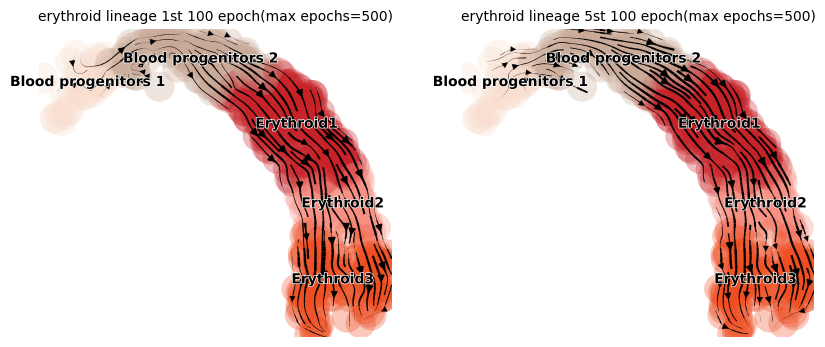

In [29]:
fig, ax = velovgi.pl.calc_fig(len(nst_list))
for i in range(len(nst_list)):
    name = name_list[i]
    tmp_adata = adata_list[i]
    scv.tl.velocity_graph(tmp_adata)
    scv.pl.velocity_embedding_stream(tmp_adata, color=cluster_key, ax=ax[i], title=name, show=False)

这里的可以发现，在训练前期间变化最大（可视化结果和损失函数上都能够看出来），因此不要等间隔地训练模型了，而是要指定epoch停一下，保存一下，再训练

3. 绘制基因速率图，暂时这么绘制吧

In [30]:
gene_list = ["Hba-x", "Hbb-y", "Smim1"]

In [31]:
from scvelo.pl.utils import default_size

size = default_size(adata)*math.log(adata.shape[0]) # 箭头的缩放比例

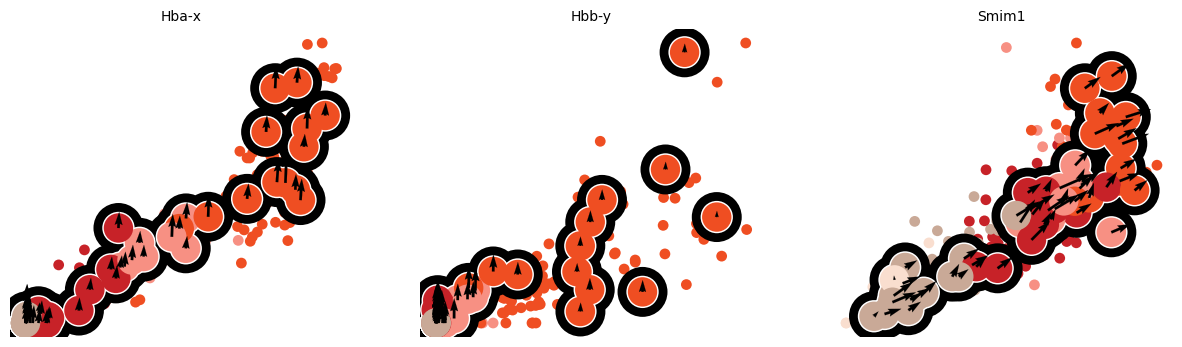

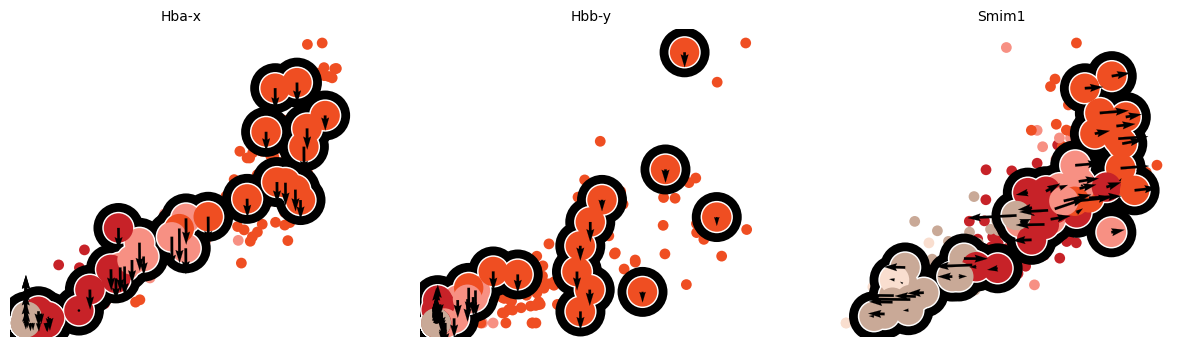

In [32]:
velovgi.pl.draw_velocity_gene_list(adata_list[0], gene_list, cluster_key=cluster_key)
velovgi.pl.draw_velocity_gene_list(adata_list[1], gene_list, cluster_key=cluster_key)